In [ ]:
import pandas as pd
import os
import numpy as np
from extract_audio_functions import * # importa como módulo completo
import importlib


# Leer el CSV
df = pd.read_csv("./dataset/spotify_songs_download.csv")

paths_audios_wav=df['path_download_wav'].tolist()
paths_audios_mp3=df['path_download'].tolist()


In [ ]:
from extract_audio_functions import *

# pasar de mp3 a wav
for i in range(0,len(paths_audios_wav)):
    entrad= paths_audios_mp3[i]
    salida = paths_audios_wav[i]
    if entrad.endswith(".mp3"):
        transform_mp3_to_wav(entrad,salida,tiempo_recorte=30)  # el path y el directorio de salida
    else:
        print(f"El archivo {entrad} no es un mp3, se omite la conversión.")


In [12]:

# Obtener listas desde el DataFrame
paths_audios_wav = df["path_download_wav"].tolist()

mfcc_por_track = []
for path_wav in paths_audios_wav:
    mfcc = extract_mfcc(path_wav, ventana=0.5)  # Captura de 0.5 segundos
    mfcc_por_track.append( mfcc)



In [13]:
mfcc_por_track[0].shape # cada audio

(60, 13)

In [14]:
#apilar los mfcc
mfcc_apilados= np.vstack(mfcc_por_track)
print(f"Forma de los MFCC apilados: {mfcc_apilados.shape}")

Forma de los MFCC apilados: (174780, 13)


In [ ]:
#df.head()

In [27]:

#NORMALIZAR LA DATA PARA EL KMEANS
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
mfcc_normalizado=scaler.fit_transform(mfcc_apilados)

# Sacamos lo Codeword   -> acoustic word
Kmeans =construir_codebook(mfcc_normalizado,n_clusters=110)
#inertia : cuando se aumenta el K la inertia tiende a 0  : significa que tanto estan pegados los puntos. 

#save scaler y kmeans -> para procesar luego una query
guardar_objeto(scaler,"scaler.joblib")
guardar_objeto(Kmeans,"Kmeans.joblib")

Initialization complete
Iteration 0, inertia 1041887.4375.
Iteration 1, inertia 953430.75.
Iteration 2, inertia 932928.9375.
Iteration 3, inertia 922761.125.
Iteration 4, inertia 916594.375.
Iteration 5, inertia 912444.8125.
Iteration 6, inertia 909305.75.
Iteration 7, inertia 906881.5625.
Iteration 8, inertia 904955.25.
Iteration 9, inertia 903423.5.
Iteration 10, inertia 902187.75.
Iteration 11, inertia 901194.875.
Iteration 12, inertia 900346.125.
Iteration 13, inertia 899626.0625.
Iteration 14, inertia 899010.75.
Iteration 15, inertia 898476.875.
Iteration 16, inertia 897998.125.
Iteration 17, inertia 897570.5625.
Iteration 18, inertia 897145.875.
Iteration 19, inertia 896731.25.
Iteration 20, inertia 896347.875.
Iteration 21, inertia 896004.0.
Iteration 22, inertia 895693.375.
Iteration 23, inertia 895409.9375.
Iteration 24, inertia 895159.375.
Iteration 25, inertia 894910.6875.
Iteration 26, inertia 894658.375.
Iteration 27, inertia 894436.125.
Iteration 28, inertia 894243.3125.


In [28]:
print(Kmeans.cluster_centers_.shape)  # (250, 13)
#print(Kmeans.cluster_centers_)        # valores de cada centroide


(110, 13)


In [29]:

track_ids = df['track_id'].tolist() 

diccionary={}
for i in range(0,len(mfcc_por_track)):
    mfcc = mfcc_por_track[i]

    #volvemos a normalizar 
    mfcc_scaled = scaler.transform(mfcc)

    hist = histogram_audio(mfcc_scaled, Kmeans)
    diccionary[track_ids[i]] = hist.tolist() #   para guardar track_id : histograma

    # (DEBUG) mostrar mapeo
    print(f"Audio {i} → {hist.tolist()}")

# Guardar en JSON
guardar_json(diccionary)


Audio 0 → [0.0, 0.1270001270001905, 0.0, 0.06350006350009525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1270001270001905, 0.0, 0.0, 0.19050019050028574, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06350006350009525, 0.0, 0.0, 0.0, 0.0, 0.31750031750047625, 0.0, 0.0, 0.06350006350009525, 0.0, 0.0, 0.1270001270001905, 0.0, 0.254000254000381, 0.0, 0.0, 0.0, 0.0, 0.31750031750047625, 0.0, 0.0, 0.06350006350009525, 0.0, 0.0, 0.0, 0.06350006350009525, 0.0, 0.06350006350009525, 0.0, 0.0, 0.06350006350009525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06350006350009525, 0.0, 0.0, 0.0, 0.5715005715008572, 0.06350006350009525, 0.0, 0.06350006350009525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06350006350009525, 0.06350006350009525, 0.0, 0.0, 0.0, 0.0, 0.1270001270001905, 0.0, 0.0, 0.0, 0.0, 0.1270001270001905, 0.06350006350009525, 0.0, 0.0, 0.0, 0.06350006350009525, 0.0, 0.0, 0.0, 0.19050019050028574, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4445004445006667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Audio 1 → [0.0, 0.0, 0.0, 0.0557

In [ ]:
from extract_audio_functions import *
import os

# TEST MUSIC
def cargar_modelos_y_datos():
    df = pd.read_csv("./dataset/spotify_songs_download.csv")
    scaler = cargar_objeto("scaler.joblib")
    kmeans_model = cargar_objeto("Kmeans.joblib")
    return df, scaler, kmeans_model
def sacar_path_con_track_id(df,track_id) -> str:
    path=df[df['track_id'] == track_id]['path_download_wav'].values[0]
    return path

def extraer_mfcc_por_path(path, scaler) -> list[list[float]]:
    mfcc_test = extract_mfcc(path)
    return scaler.transform(mfcc_test)

def obtener_recomendaciones_por_track(track_id: str, k: int = 5) -> tuple[dict[str, any], int]:
    try:
        df, scaler, kmeans_model = cargar_modelos_y_datos()

        if track_id not in df['track_id'].values:
            return {"error": "Track ID no encontrado"}, 404
        
        path=sacar_path_con_track_id(df,track_id)
        mfcc_normalizado = extraer_mfcc_por_path(path,scaler)
        histograma = histogram_audio(mfcc_normalizado, kmeans_model)
        recomendaciones = knn_manhattan(histograma, k=k)
        
        # Convertir a dict si es lista de tuplas
        recomendaciones_dict = {track: dist for track, dist in recomendaciones}

        return {"recomendaciones": recomendaciones_dict}, 200

    except Exception as e:
        return {"error": str(e)}, 500

#--------------- TEST adudio MP3 --------------

def obtener_recomendaciones_por_audio_mp3(path_mp3,k=5):
    """
        path absoulta d la ruta
    """
    directorio='./audios_temp'
    if not os.path.isdir(directorio):
        print(f"creando directorio ... {directorio}")
        os.makedirs(directorio)

    path_salida = directorio+"/temp.wav"
    path_mp3_salida_wav=os.path.abspath(path_salida)

    transform_mp3_to_wav(path_mp3,path_mp3_salida_wav)
    scaler = cargar_objeto("scaler.joblib")
    kmeans_model = cargar_objeto("Kmeans.joblib")
    mfcc_normalizado=extraer_mfcc_por_path(path_mp3_salida_wav,scaler)

    histograma = histogram_audio(mfcc_normalizado, kmeans_model)
    recomendaciones = knn_cosine(histograma, k=k)
    recomendaciones_dict=dict(recomendaciones)
    return {"recomendaciones": recomendaciones_dict}, 200




# ---- TEST INSERT AUDIO ---- 
path_mp3='capital_cities.mpeg'

import shutil
import os

directorio = './audios'
if not os.path.isdir(directorio):
    print(f"Creando directorio{directorio}...")
    os.makedirs(directorio, exist_ok=True)

path_para_copiar = os.path.abspath(directorio)
nombre_archivo = os.path.basename(path_mp3)  # extrae solo el nombre.mp3

destino_completo = os.path.join(path_para_copiar, nombre_archivo)

shutil.copy(path_mp3, destino_completo)

path_mp3=destino_completo
transform_mp3_to_wav(path_mp3,path_mp3_salida_wav)
#scaler = cargar_objeto("scaler.joblib")
#kmeans_model = cargar_objeto("Kmeans.joblib")
#mfcc_normalizado=extraer_mfcc_por_path(path_mp3,scaler)

#histograma = histogram_audio(mfcc_normalizado, kmeans_model)



Convertido: C:\Users\jefersson\Downloads\capital_cities.mpeg → C:\Users\jefersson\Desktop\ANACONDA\audios_wav\temp.wav


In [ ]:
#path_mp3="C:\\Users\\jefersson\\Downloads\\coldplay.mpeg"
path_mp3="C:\\Users\\jefersson\\Downloads\\capital_cities.mpeg" 

recomendaciones=obtener_recomendaciones_por_audio_mp3(path_mp3=path_mp3,k=5)


import os
cwd = os.getcwd()
print("Directorio actual:", cwd)

path=os.path.join(cwd,'audio_temp','temp.wav')
print(path)

print(os.path.abspath('./audios_wav/jessie j - masterpiece.wav'))
print(os.path.abspath('.\\audios\\ann marie, yk osiris - secret .mp3'))


Directorio actual: c:\Users\jefersson\Desktop\ANACONDA
c:\Users\jefersson\Desktop\ANACONDA\audio_temp\temp.wav
c:\Users\jefersson\Desktop\ANACONDA\audios_wav\jessie j - masterpiece.wav
c:\Users\jefersson\Desktop\ANACONDA\audios\ann marie, yk osiris - secret .mp3


In [ ]:
result_dict=recomendaciones['recomendaciones']

In [24]:
#result_dict,status = obtener_recomendaciones_por_track('7qpuECko60EoztznowMWj1',k=5)
#result_dict=result_dict['recomendaciones']
import pandas as pd

# Leer el CSV
df = pd.read_csv("./dataset/spotify_songs_download.csv")


filas = df[df['track_id'].isin(result_dict)]
filas
# Agregar la columna 'score' con la distancia correspondiente
filas['score'] = filas['track_id'].map(result_dict)
#print(filas)


C:\Users\jefersson\AppData\Local\Temp\ipykernel_11968\3375615532.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filas['score'] = filas['track_id'].map(result_dict)


In [25]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

# Leer dataset original con géneros
df_genre = pd.read_csv('./dataset/spotify_songs_download_FINAL.csv')

# Ordenar por score
filas = filas.sort_values('score')

# Hacer el join por track_id
join_data = pd.merge(df_genre, filas, on='track_id', how='inner')

# Mostrar columnas deseadas
join_data.sort_values('score')[['score', 'track_artist_x', 'track_name_x', 'playlist_genre', 'playlist_subgenre', 'path_download_y']]


,score,track_artist_x,track_name_x,playlist_genre,playlist_subgenre,path_download_y
4,0.944194,Dannic,Dear Life - Bassjackers Remix,edm,progressive electro house,"C:\Users\jefersson\Desktop\ANACONDA\audios\dannic, bright lights, bassjackers - dear life - bassjackers remix.mp3"
1,0.952527,Capital Cities,Safe And Sound,pop,post-teen pop,C:\Users\jefersson\Desktop\ANACONDA\audios\capital cities - safe and sound.mp3
2,0.962228,Alesso,I Wanna Know - Alesso & Deniz Koyu Remix,pop,electropop,"C:\Users\jefersson\Desktop\ANACONDA\audios\alesso, nico & vinz, deniz koyu - i wanna know - alesso & deniz koyu remix.mp3"
0,0.976688,Five Finger Death Punch,Under and Over It,rock,hard rock,C:\Users\jefersson\Desktop\ANACONDA\audios\five finger death punch - under and over it.mp3
3,0.979233,Zomboy,WTF!? - Original Mix,edm,electro house,C:\Users\jefersson\Desktop\ANACONDA\audios\zomboy - wtf! - original mix.mp3


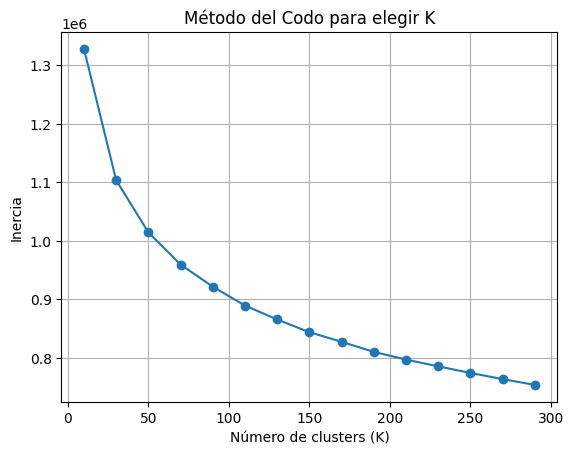

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
mfcc_normalizado=scaler.fit_transform(mfcc_apilados)

inertias = []
K_range = range(10, 300, 20)
for k in K_range:
    model = KMeans(n_clusters=k, random_state=0).fit(mfcc_normalizado)
    inertias.append(model.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para elegir K')
plt.grid()
plt.show()


In [ ]:
# Calcular distancias a cada vector en el diccionario
import numpy as np

def distancia_euclidiana(val1, val2):
    return np.linalg.norm(np.array(val1) - np.array(val2))

dis = {}
for key, val in diccionary.items():  # <-- importante usar .items()
    dist = distancia_euclidiana(val, hist)
    dis[key] = dist

for track_id, distancia in sorted(dis.items(), key=lambda x: x[1]): #key : value
    print(f"{track_id}: {distancia:.4f}")


# Ordenar y obtener los 5 más cercanos
dis_sort = sorted(dis.items(), key=lambda x: x[1]) # orden descendente : si la distancia es menor es mas parecido
top_5_ids = [track_id for track_id, _ in dis_sort[:5]]

# Obtener filas correspondientes del DataFrame
filas = df[df['track_id'].isin(top_5_ids)]
# Agregar la columna 'score' con la distancia correspondiente
filas['score'] = filas['track_id'].map(dis)
#print(filas)


In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

# Leer dataset original con géneros
df_genre = pd.read_csv('./dataset/spotify_songs_download_FINAL.csv')

# Ordenar por score
filas = filas.sort_values('score')

# Hacer el join por track_id
join_data = pd.merge(df_genre, filas, on='track_id', how='inner')

# Mostrar columnas deseadas
join_data.sort_values('score')[['score', 'track_artist_x', 'track_name_x', 'playlist_genre', 'playlist_subgenre', 'path_download_y']]


In [ ]:
import subprocess

def play_audio(path):
    subprocess.call(['ffplay', '-nodisp', '-autoexit', path])

for i in filas['path_download_wav']:
    print(f"Reproduciendo: {i}")
    #play_audio(i)  # Reproducir cada audio
    
    #input("Presiona Enter para continuar...")  # Esperar a que el usuario presione Enter antes de continuar